# **Import Semua Packages/Library yang Digunakan**

In [6]:
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import rasterio
from skimage.transform import resize
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout,
    BatchNormalization, Concatenate, GlobalAveragePooling2D
)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from tensorflow.keras import regularizers
from keras import backend as K


# **Memuat Dataset**

In [7]:
# Path Global
BASE_DIR = r"D:\Kuliah\DBS\capstone projek\project\project"
CITRA_DIR = os.path.join(BASE_DIR, "dataset", "citra_satelit")
TABULAR_PATH = os.path.join(BASE_DIR, "dataset", "tabular", "data_banjir_combine_final.csv")

In [8]:
df_tabular = pd.read_csv(TABULAR_PATH)
print("Tabular shape:", df_tabular.shape)
df_tabular.head()

Tabular shape: (18047, 17)


,NAME_2,NAME_3,avg_rainfall,max_rainfall,avg_temperature,elevation,landcover_class,ndvi,slope,soil_moisture,year,month,banjir,lat,long,map_image,NAME_3_clean
0,bogor,babakanmadang,64.775,124.032,28.76,501.913,Tree cover,0.564,5.001,39.583,2020,1,1,-6.5917,106.9020,RGB_BabakanMadang2020.tif,babakanmadang
1,bogor,bojonggede,68.241,128.949,32.89,133.589,Built-up,0.429,0.293,40.414,2020,1,1,-6.4774,106.7927,RGB_BabakanMadang2020.tif,bojonggede
2,bogor,caringin,56.423,92.324,29.93,765.651,Tree cover,0.513,4.954,39.662,2020,1,0,-6.7366,106.8660,RGB_Caringin2020(2).tif,caringin
3,bogor,cariu,60.034,98.129,30.02,143.845,Tree cover,0.652,2.107,39.014,2020,1,0,-6.5273,107.1371,RGB_BabakanMadang2020.tif,cariu
4,bogor,ciampea,66.380,133.877,30.27,212.619,Tree cover,0.569,1.340,39.658,2020,1,0,-6.5742,106.6980,RGB_Ciampea2020.tif,ciampea


In [9]:
# Hapus kolom yang tidak dibutuhkan
df_tabular.drop(columns=['NAME_2', 'long', 'lat', 'NAME_3_clean'], inplace=True)

In [10]:
def load_rgb_images(image_names, base_path, target_size=(128, 128)):
    images = []
    for name in image_names:
        name = os.path.splitext(name)[0]  # Hapus ekstensi kalau ada
        tif_path = os.path.join(base_path, f"{name}.tif")
        if not os.path.exists(tif_path):
            print(f"File tidak ditemukan: {tif_path}")
            continue

        try:
            with rasterio.open(tif_path) as src:
                # Read bands satu per satu dan resize segera
                resized_bands = []
                for i in [1, 2, 3]:  # RGB bands
                    band = src.read(i).astype(np.float32)  # (H, W)
                    band = np.nan_to_num(band, nan=0.0)
                    band_min, band_max = band.min(), band.max()
                    band = (band - band_min) / (band_max - band_min + 1e-6)
                    band_resized = resize(band, target_size, anti_aliasing=True)
                    resized_bands.append(band_resized)

                img_resized = np.stack(resized_bands)        # (3, H, W)
                img_resized = np.transpose(img_resized, (1, 2, 0))  # (H, W, 3)
                images.append(img_resized)

        except MemoryError:
            print(f"MemoryError saat memuat: {tif_path}")
            continue

    return np.array(images)

In [11]:
def show_rgb_image(tif_path):
    with rasterio.open(tif_path) as src:
        img = src.read([1, 2, 3])  # channel R, G, B

    # Tangani NaN → ganti dengan 0
    img = np.nan_to_num(img, nan=0.0)

    # Normalisasi per channel
    img = img.astype(np.float32)
    img_min, img_max = img.min(), img.max()
    img = (img - img_min) / (img_max - img_min + 1e-6)

    # Transpose untuk imshow
    img = np.transpose(img, (1, 2, 0))

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(tif_path.split("/")[-1])
    plt.show()


# **EDA**

In [12]:
df_tabular.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18047 entries, 0 to 18046
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   NAME_3           18047 non-null  object 
 1   avg_rainfall     18047 non-null  float64
 2   max_rainfall     18047 non-null  float64
 3   avg_temperature  18047 non-null  float64
 4   elevation        18047 non-null  float64
 5   landcover_class  18047 non-null  object 
 6   ndvi             18047 non-null  float64
 7   slope            18047 non-null  float64
 8   soil_moisture    18047 non-null  float64
 9   year             18047 non-null  int64  
 10  month            18047 non-null  int64  
 11  banjir           18047 non-null  int64  
 12  map_image        18047 non-null  object 
dtypes: float64(7), int64(3), object(3)
memory usage: 1.8+ MB


In [13]:
print(df_tabular.describe())

       avg_rainfall  max_rainfall  avg_temperature     elevation  \
count  18047.000000  18047.000000     18047.000000  18047.000000   
mean      44.969022     83.676593        32.182496    155.967521   
std       25.480935     44.370820         4.676819    256.414214   
min        0.525000      0.858000        11.490000      0.000000   
25%       25.171000     52.819000        28.500000     13.259000   
50%       42.294000     77.859000        31.660000     43.009000   
75%       60.995500    108.645500        36.217500    164.829000   
max      222.600000    386.707000        43.830000   1814.735000   

               ndvi         slope  soil_moisture          year         month  \
count  18047.000000  18047.000000   18047.000000  18047.000000  18047.000000   
mean       0.491865      1.391249      36.306754   2022.100848      6.330747   
std        0.181190      2.164682       3.911832      1.390713      3.680336   
min        0.082000      0.000000      13.210000   2020.000000     

In [14]:
df_no_flood = df_tabular[df_tabular['banjir'] == 0]

# Hitung jumlah daerah unik yang tidak banjir per tahun
jumlah_daerah_tidak_banjir = df_no_flood.groupby('year')['NAME_3'].nunique().reset_index(name='jumlah_daerah_tidak_banjir')

print(jumlah_daerah_tidak_banjir)

   year  jumlah_daerah_tidak_banjir
0  2020                         180
1  2021                         180
2  2022                         180
3  2023                         180
4  2024                         180


In [15]:
# Hitung frekuensi bulan tidak banjir per daerah setiap tahun
bulan_tidak_banjir_per_daerah = df_no_flood.groupby(['year', 'NAME_3']).size().reset_index(name='jumlah_bulan_tidak_banjir')

print(bulan_tidak_banjir_per_daerah)

     year         NAME_3  jumlah_bulan_tidak_banjir
0    2020  babakanmadang                         11
1    2020        babelan                          9
2    2020       balaraja                         12
3    2020   bantargebang                          9
4    2020      batuceper                         12
..    ...            ...                        ...
895  2024          tebet                         12
896  2024      teluknaga                         11
897  2024          tenjo                         12
898  2024      tenjolaya                         12
899  2024      tigaraksa                         12

[900 rows x 3 columns]


## Missing value

In [16]:
df_tabular.isnull().sum()

NAME_3             0
avg_rainfall       0
max_rainfall       0
avg_temperature    0
elevation          0
landcover_class    0
ndvi               0
slope              0
soil_moisture      0
year               0
month              0
banjir             0
map_image          0
dtype: int64

## Duplicate

In [17]:
df_tabular.duplicated().sum()

0

Undersampling Data

In [18]:
# Target per kelas
target_per_class = 7000

# Pisahkan data berdasarkan kelas
df_banjir = df_tabular[df_tabular['banjir'] == 1]
df_tidak_banjir = df_tabular[df_tabular['banjir'] == 0]

# --- Sampling data banjir ---
df_banjir_sampled = df_banjir.sample(n=target_per_class, random_state=42)

# --- Sampling proporsional data tidak banjir per tahun ---
proporsi_tidak_banjir_per_tahun = (
    df_tidak_banjir['year'].value_counts(normalize=True).sort_index()
)

# Buat daftar simpan
df_tidak_banjir_balanced = []
sudah_diambil = pd.DataFrame()

for tahun, proporsi in proporsi_tidak_banjir_per_tahun.items():
    df_tahun = df_tidak_banjir[df_tidak_banjir['year'] == tahun]
    n_sample = min(int(target_per_class * proporsi), len(df_tahun))
    sampled = df_tahun.sample(n=n_sample, random_state=42)
    df_tidak_banjir_balanced.append(sampled)
    sudah_diambil = pd.concat([sudah_diambil, sampled])

# Gabungkan hasil sampling awal
df_tidak_banjir_balanced = pd.concat(df_tidak_banjir_balanced)

# Hitung kekurangan
kurang = target_per_class - len(df_tidak_banjir_balanced)
if kurang > 0:
    sisa_data = df_tidak_banjir.drop(sudah_diambil.index)
    top_up = sisa_data.sample(n=kurang, random_state=99)
    df_tidak_banjir_balanced = pd.concat([df_tidak_banjir_balanced, top_up])

# Gabungkan keduanya
df_balanced = pd.concat([df_banjir_sampled, df_tidak_banjir_balanced])

# Shuffle dan reset index
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Cek hasil
print("Distribusi kelas:")
print(df_balanced['banjir'].value_counts())

print("\nDistribusi tahun:")
print(df_balanced['year'].value_counts())


Distribusi kelas:
banjir
1    7000
0    7000
Name: count, dtype: int64

Distribusi tahun:
year
2024    3070
2022    3012
2023    2796
2021    2792
2020    2330
Name: count, dtype: int64


## Distribusi Data Numerik

<Figure size 1500x1000 with 0 Axes>

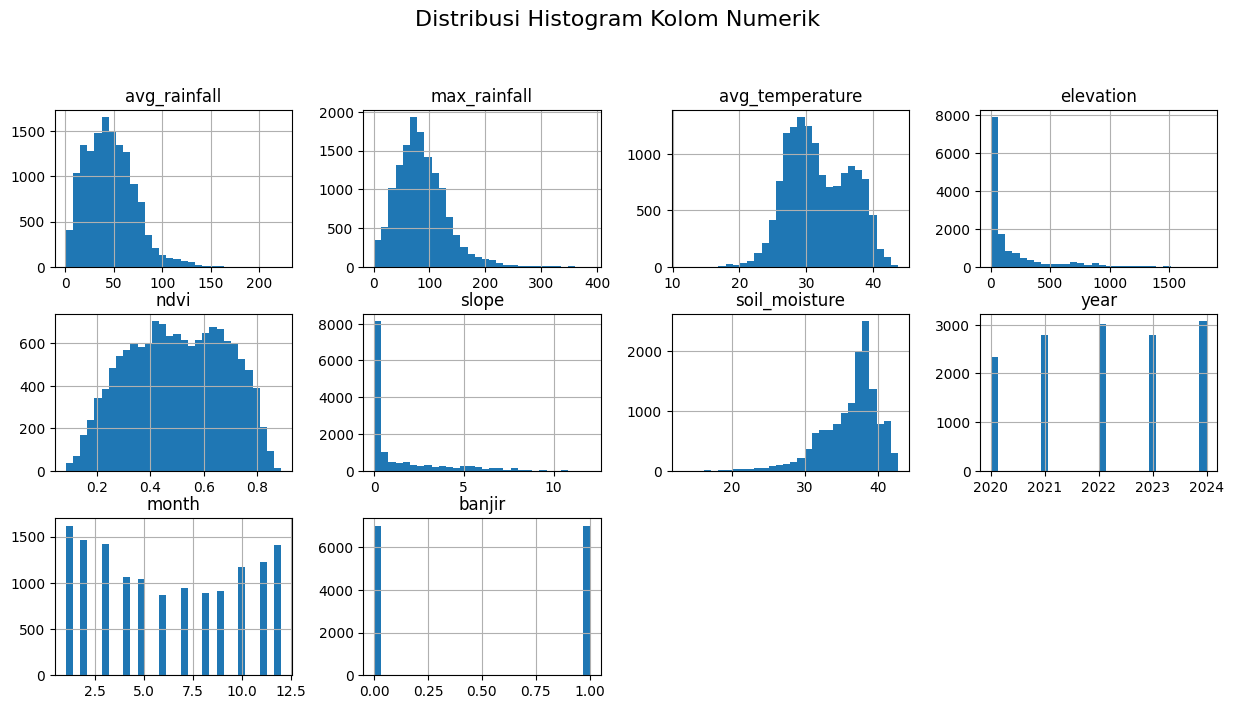

In [19]:
# Pilih hanya kolom numerik
numerical_columns = df_balanced.select_dtypes(include=['int64', 'float64']).columns

# Plot histogram untuk setiap kolom numerik
plt.figure(figsize=(15, 10))
df_balanced[numerical_columns].hist(bins=30, figsize=(15, 10), layout=(4, 4))
plt.suptitle("Distribusi Histogram Kolom Numerik", fontsize=16)
plt.show()

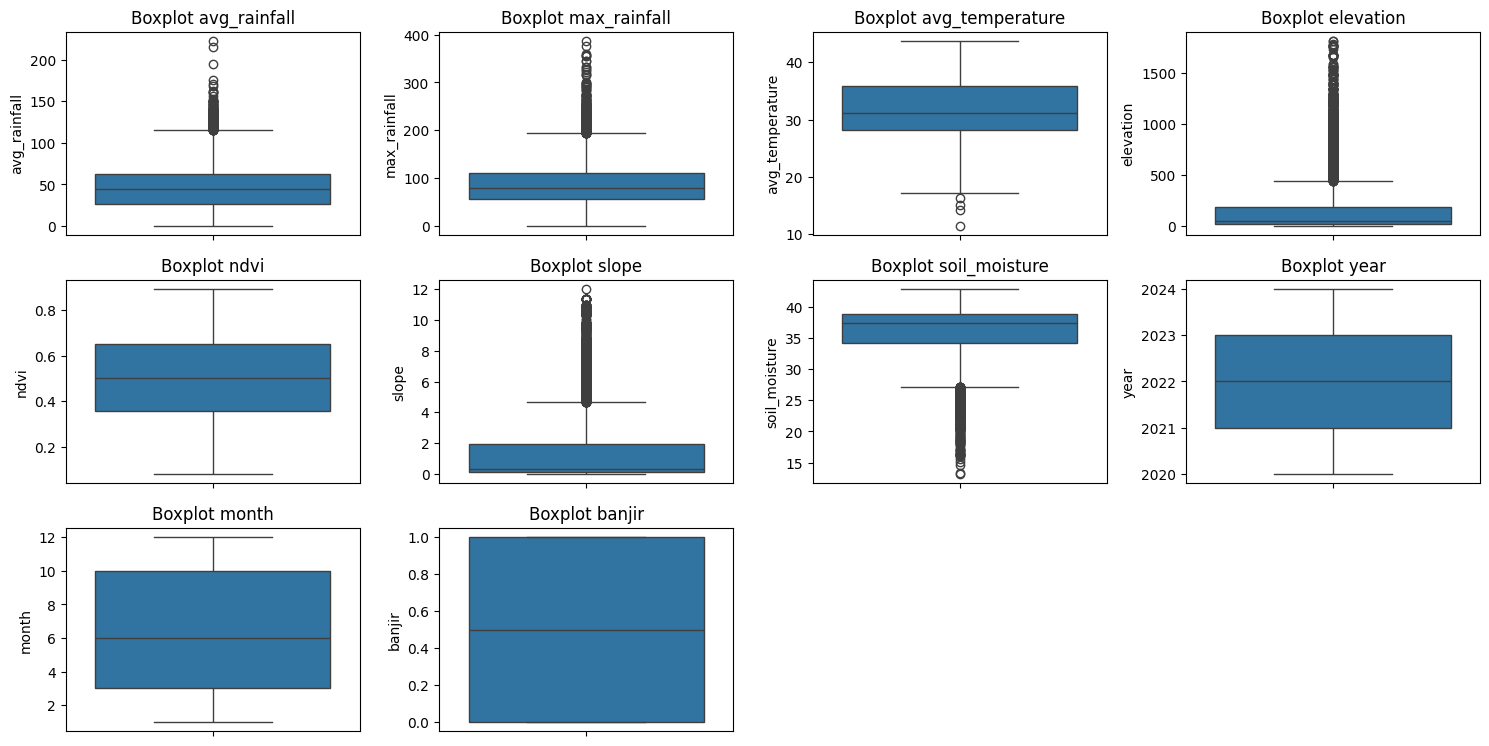

In [20]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=df_balanced[col])
    plt.title(f"Boxplot {col}")
    plt.tight_layout()

plt.show()

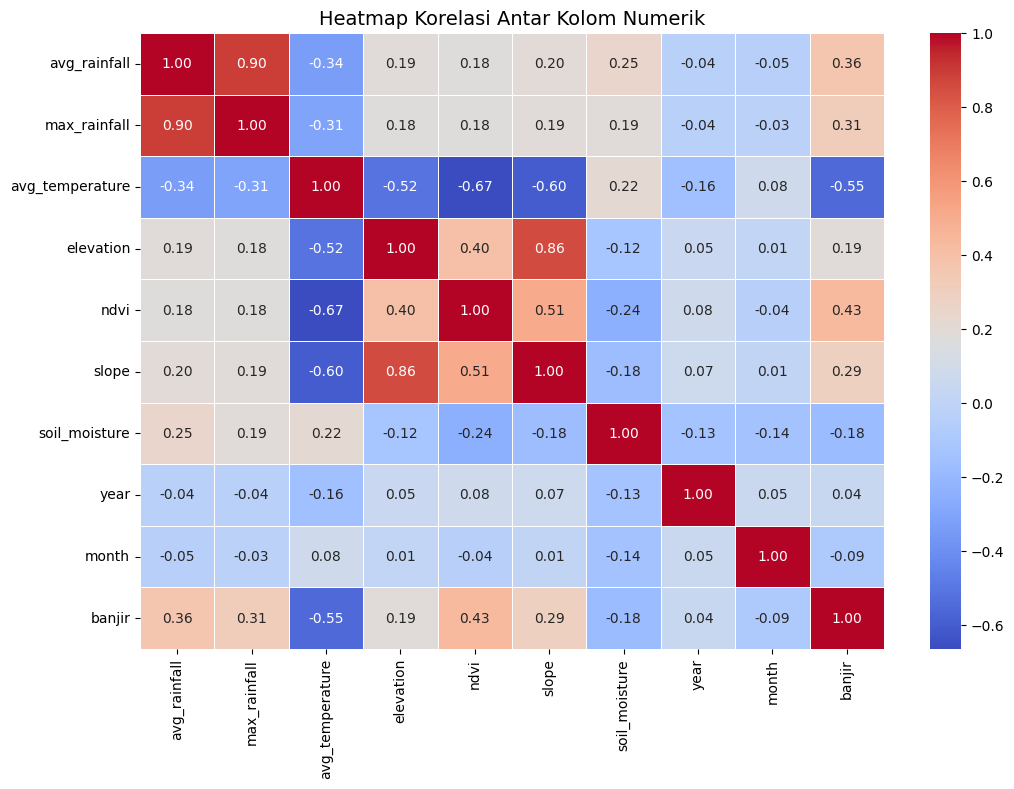

In [21]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_balanced[numerical_columns].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Kolom Numerik", fontsize=14)
plt.show()

## Distribusi Data Kategorikal

In [22]:
categorical_columns = df_balanced.select_dtypes(include=['object']).columns
print(categorical_columns)

Index(['NAME_3', 'landcover_class', 'map_image'], dtype='object')


In [23]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   NAME_3           14000 non-null  object 
 1   avg_rainfall     14000 non-null  float64
 2   max_rainfall     14000 non-null  float64
 3   avg_temperature  14000 non-null  float64
 4   elevation        14000 non-null  float64
 5   landcover_class  14000 non-null  object 
 6   ndvi             14000 non-null  float64
 7   slope            14000 non-null  float64
 8   soil_moisture    14000 non-null  float64
 9   year             14000 non-null  int64  
 10  month            14000 non-null  int64  
 11  banjir           14000 non-null  int64  
 12  map_image        14000 non-null  object 
dtypes: float64(7), int64(3), object(3)
memory usage: 1.4+ MB


D:\Temp\ipykernel_21308\2516699739.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_balanced[col], order=df_balanced[col].value_counts().index[:10], palette="viridis")
D:\Temp\ipykernel_21308\2516699739.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_balanced[col], order=df_balanced[col].value_counts().index[:10], palette="viridis")
D:\Temp\ipykernel_21308\2516699739.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_balanced[col], order=df_balanced[col].value_counts().index[:10], palette="viridis")


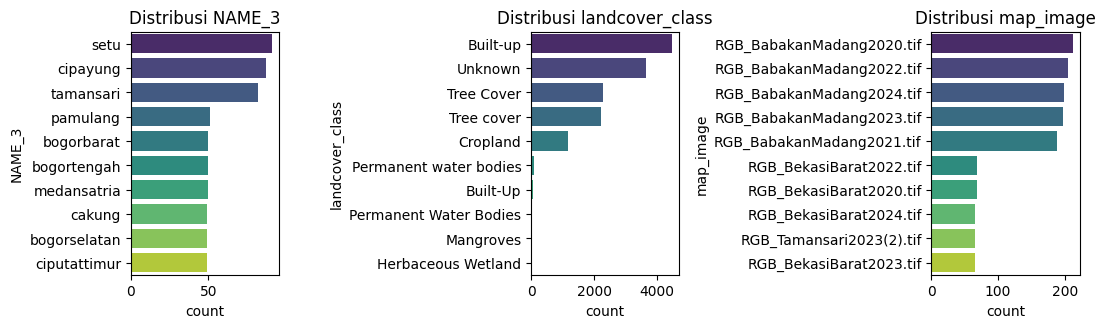

In [24]:
plt.figure(figsize=(15, 12))

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(4, 4, i)
    sns.countplot(y=df_balanced[col], order=df_balanced[col].value_counts().index[:10], palette="viridis")
    plt.title(f"Distribusi {col}")
    plt.tight_layout()

plt.show()

# **Data Preprocessing**

## Membersihkan outlier

In [25]:
# Kolom-kolom dengan outlier
outlier_columns = ['avg_rainfall', 'max_rainfall', 'avg_temperature',
                   'elevation', 'slope', 'soil_moisture']

# Winsorize setiap kolom (menghapus 1% bawah dan 1% atas sebagai contoh)
for col in outlier_columns:
    df_balanced[col] = winsorize(df_balanced[col], limits=[0.01, 0.01])

# Cek hasil
print(df_balanced[outlier_columns].describe())

       avg_rainfall  max_rainfall  avg_temperature     elevation  \
count  14000.000000  14000.000000     14000.000000  14000.000000   
mean      46.120118     85.294259        31.871633    160.426615   
std       24.824614     42.844244         4.610473    252.605246   
min        3.434000      6.819000        22.390000      2.773000   
25%       26.924000     55.449500        28.230000     14.287000   
50%       43.986500     80.236500        31.180000     46.555000   
75%       62.145500    110.620000        35.910000    184.459000   
max      123.053000    223.043000        41.120000   1207.359000   

              slope  soil_moisture  
count  14000.000000   14000.000000  
mean       1.456752      36.262591  
std        2.159176       3.842344  
min        0.046000      22.846000  
25%        0.130000      34.107500  
50%        0.293000      37.334000  
75%        1.946000      38.758000  
max        8.730000      42.223000  


In [26]:
# Pilih hanya kolom bertipe object (kategorikal)
categorical_columns = df_balanced.select_dtypes(include=['object'])

# Hitung jumlah kategori unik di setiap kolom kategorikal
category_counts = categorical_columns.nunique()

# Tampilkan hasil
print(category_counts)

NAME_3             2626
landcover_class      11
map_image          4918
dtype: int64


In [27]:
onehot_cols = ['landcover_class']

In [28]:
# Pipeline untuk tiap tipe data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

label_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())  # atau bisa diganti TargetEncoder jika pakai library `category_encoders`
])

In [29]:
# Gabungkan dengan ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns),
        ('cat', categorical_transformer, onehot_cols),
    ]
)

In [30]:
# Fit-transform data tabular
X_processed = preprocessor.fit_transform(df_balanced)

# Target
y = df_balanced['banjir']

## Split Dataset

### Data Tabular

In [31]:
# Urutkan berdasarkan lokasi dan waktu
df_balanced = df_balanced.sort_values(by=['NAME_3', 'year', 'month'])

# Geser label banjir ke bulan berikutnya
df_balanced['banjir_next'] = df_balanced.groupby('NAME_3')['banjir'].shift(-1)

# Buang baris yang tidak punya target banjir_next (biasanya akhir 2024 atau akhir data)
df_balanced = df_balanced.dropna(subset=['banjir_next'])
df_balanced['banjir_next'] = df_balanced['banjir_next'].astype(int)

In [32]:
# Split berdasarkan tahun
train_data = df_balanced[df_balanced['year'] < 2024]
test_data  = df_balanced[df_balanced['year'] == 2024]


In [33]:
# Pisahkan fitur tabular dan target
X_train_raw = train_data.copy()
X_test_raw = test_data.copy()

y_train = X_train_raw['banjir_next']
y_test  = X_test_raw['banjir_next']


In [34]:
X_train = preprocessor.fit_transform(X_train_raw)
X_test  = preprocessor.transform(X_test_raw)


### Data Gambar

In [35]:
# Ambil nama file gambar dari kolom map_image
map_train = X_train_raw["map_image"].values
map_test = X_test_raw["map_image"].values

# Load citra dari folder CITRAz_DIR
X_train_img = load_rgb_images(map_train, base_path=CITRA_DIR)
X_test_img = load_rgb_images(map_test, base_path=CITRA_DIR)

print(f"Jumlah citra berhasil dimuat: {len(X_train_img)}")
print(f"Jumlah data tabular: {len(X_train)}")
print(f"Jumlah label: {len(y_train)}")

Jumlah citra berhasil dimuat: 9624
Jumlah data tabular: 9624
Jumlah label: 9624


# **Modeling**

## callback

In [36]:
# Buat direktori simpan model jika belum ada
checkpoint_dir = os.path.join(BASE_DIR, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

# Path file model yang disimpan
checkpoint_path = os.path.join(checkpoint_dir, "model_multimodal_best.h5")

# Callback
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]

## Bangun model multimodal (CNN + MLP)

In [37]:
# === CNN untuk citra RGB satelit ===
image_input = Input(shape=(128, 128, 3), name="image_input")

x = Conv2D(32, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(1e-4))(image_input)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.3)(x)

# === MLP untuk data tabular ===
tabular_input = Input(shape=(X_train.shape[1],), name="tabular_input")

y = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(tabular_input)
y = BatchNormalization()(y)
y = Dropout(0.3)(y)

# === Gabungkan CNN dan MLP ===
combined = Concatenate()([x, y])
z = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(combined)
z = Dropout(0.3)(z)

output = Dense(1, activation='sigmoid')(z)

# === Bangun model multimodal ===
model = Model(inputs=[image_input, tabular_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Ringkasan model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ max_pooling2d_2[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      1,344 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0] 

 Total params: 112,321 (438.75 KB)

 Trainable params: 111,745 (436.50 KB)

 Non-trainable params: 576 (2.25 KB)

In [38]:
history = model.fit(
    {'image_input': X_train_img, 'tabular_input': X_train},
    y_train,
    validation_data=({'image_input': X_test_img, 'tabular_input': X_test}, y_test),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    # class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8745 - loss: 0.3603
Epoch 1: val_loss improved from inf to 0.22247, saving model to D:\Kuliah\DBS\capstone projek\project\project\checkpoints\model_multimodal_best.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 70s 224ms/step - accuracy: 0.8746 - loss: 0.3601 - val_accuracy: 0.9251 - val_loss: 0.2225 - learning_rate: 0.0010
Epoch 2/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9268 - loss: 0.2512
Epoch 2: val_loss improved from 0.22247 to 0.12602, saving model to D:\Kuliah\DBS\capstone projek\project\project\checkpoints\model_multimodal_best.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 67s 224ms/step - accuracy: 0.9268 - loss: 0.2512 - val_accuracy: 0.9823 - val_loss: 0.1260 - learning_rate: 0.0010
Epoch 3/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9299 - loss: 0.2410
Epoch 3: val_loss improved from 0.12602 to 0.11791, saving model to D:\Kuliah\DBS\capstone projek\project\project\checkpoints\model_multimodal_best.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 67s 223ms/step - accuracy: 0.9299 - loss: 0.2410 - val_accuracy: 0.9789 - val_loss: 0.1179 - learning_rate: 0.0010
Epoch 4/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9308 - loss: 0.2304
Epoch 4: val_loss did not improve from 0.11791
301/301 ━━━━━━━━━━━━━━━━━━━━ 67s 222ms/step - accuracy: 0.9308 - loss: 0.2304 - val_accuracy: 0.9709 - val_loss: 0.1385 - learning_rate: 0.0010
Epoch 5/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9304 - loss: 0.2256
Epoch 5: val_loss improved from 0.11791 to 0.11352, saving model to D:\Kuliah\DBS\capstone projek\project\project\checkpoints\model_multimodal_best.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 67s 221ms/step - accuracy: 0.9304 - loss: 0.2256 - val_accuracy: 0.9834 - val_loss: 0.1135 - learning_rate: 0.0010
Epoch 6/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9288 - loss: 0.2212
Epoch 6: val_loss did not improve from 0.11352
301/301 ━━━━━━━━━━━━━━━━━━━━ 67s 224ms/step - accuracy: 0.9288 - loss: 0.2212 - val_accuracy: 0.9549 - val_loss: 0.1754 - learning_rate: 0.0010
Epoch 7/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9302 - loss: 0.2185
Epoch 7: val_loss improved from 0.11352 to 0.10917, saving model to D:\Kuliah\DBS\capstone projek\project\project\checkpoints\model_multimodal_best.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 67s 223ms/step - accuracy: 0.9302 - loss: 0.2185 - val_accuracy: 0.9829 - val_loss: 0.1092 - learning_rate: 0.0010
Epoch 8/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9309 - loss: 0.2151
Epoch 8: val_loss did not improve from 0.10917
301/301 ━━━━━━━━━━━━━━━━━━━━ 68s 225ms/step - accuracy: 0.9309 - loss: 0.2151 - val_accuracy: 0.9577 - val_loss: 0.1888 - learning_rate: 0.0010
Epoch 9/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9332 - loss: 0.2029
Epoch 9: val_loss improved from 0.10917 to 0.09475, saving model to D:\Kuliah\DBS\capstone projek\project\project\checkpoints\model_multimodal_best.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 67s 222ms/step - accuracy: 0.9332 - loss: 0.2029 - val_accuracy: 0.9886 - val_loss: 0.0947 - learning_rate: 0.0010
Epoch 10/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9306 - loss: 0.2073
Epoch 10: val_loss did not improve from 0.09475
301/301 ━━━━━━━━━━━━━━━━━━━━ 67s 222ms/step - accuracy: 0.9305 - loss: 0.2073 - val_accuracy: 0.9611 - val_loss: 0.1880 - learning_rate: 0.0010
Epoch 11/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9289 - loss: 0.2100
Epoch 11: val_loss did not improve from 0.09475
301/301 ━━━━━━━━━━━━━━━━━━━━ 67s 221ms/step - accuracy: 0.9289 - loss: 0.2100 - val_accuracy: 0.9823 - val_loss: 0.1338 - learning_rate: 0.0010
Epoch 12/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9283 - loss: 0.2115
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: val_loss did not improve from 0.09475
301/301 ━━━━━━━━━━━━━━━━━━━━ 66s 220ms/step - accuracy: 0.9284 - loss: 0.2114 -

In [39]:
model.export("saved_model/flood-sight")

INFO:tensorflow:Assets written to: saved_model/flood-sight\assets


INFO:tensorflow:Assets written to: saved_model/flood-sight\assets


Saved artifact at 'saved_model/flood-sight'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='image_input'), TensorSpec(shape=(None, 20), dtype=tf.float32, name='tabular_input')]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2341030640656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2340994667568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2341034296240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2341034310672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2341034298704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2341034300288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2341034297296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2341030506592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2341030506416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2341030500256: Tenso

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1341
           1       0.99      0.96      0.98       409

    accuracy                           0.99      1750
   macro avg       0.99      0.98      0.98      1750
weighted avg       0.99      0.99      0.99      1750



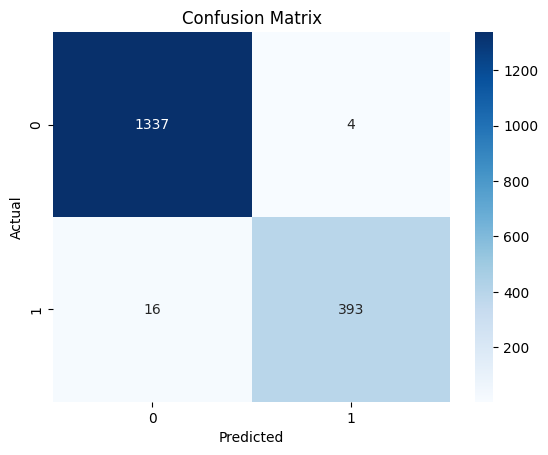

In [40]:
# Prediksi
from sklearn.metrics import classification_report, confusion_matrix


y_pred_prob = model.predict([X_test_img, X_test])
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluasi
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


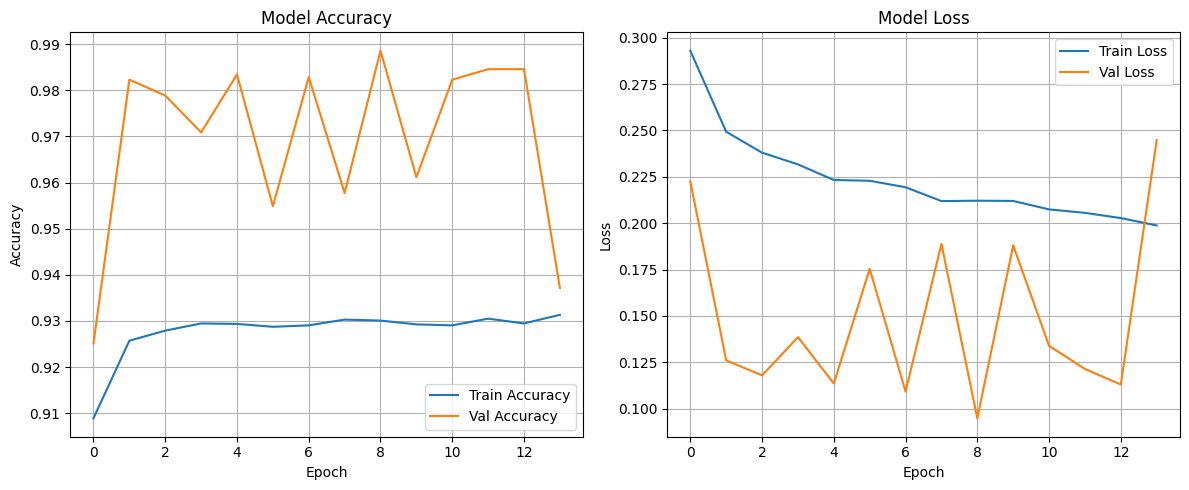

In [41]:
# Plot Akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [42]:
# Buat folder untuk simpan model & preprocessor jika belum ada
os.makedirs("saved_model", exist_ok=True)

In [43]:
# === Simpan model TensorFlow ===
import pickle


model.save("saved_model/flood-sight.keras")  # menyimpan model lengkap

# === (Opsional) Simpan preprocessing pipeline ===
# Misal: scaler, encoder, atau imputer
with open("saved_model/preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f)  # Ganti dengan pipeline aslinya

# === (Opsional) Simpan history training ===
with open("saved_model/history.pkl", "wb") as f:
    pickle.dump(history.history, f)
